In [2]:
import os
from btgenerate.chemicals.chemical import Chemical
from btgenerate.database.database import Database
from btgenerate.database.dataloader import LiquidMasterDataSet
from pprint import pprint, PrettyPrinter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pp = PrettyPrinter(width=80, compact=True)
%reload_ext autoreload
%autoreload 1
%aimport btgenerate.chemicals.chemical
%aimport btgenerate.database.database


In [22]:
db = Database(db="FMT")
df = db.pull(table="Liquid Master Table")

ds_lm = LiquidMasterDataSet(df)
ds_lm.map_names()
ds_lm.normalize_components(by="total_mass(g)", inplace=True)

In [23]:
df.loc[~df["lab_batch"].isna()]

,Electrolyte ID,lab_batch,note,total_mass(g),generation_method,generation_project,experiment,LiPF6,LiTFSI,LiFSI,...,TFMB,Conductivity,Voltage,Cycles,LCE,Initial Li efficiency,generation_id,Predicted Conductivity,Predicted Voltage,Predicted LCE
154,21-1-41,6.0,b'baseline',10.026,manual,DOE_electrolyte,BL-1,0.058,1.146,0.000,...,NaN,NaN,NaN,43.0,0.928058,0.888592,NaN,0.0,0.0,0.0
155,21-1-42,6.0,b'128 day 2 reference',4.989,manual,DOE_electrolyte,None,0.000,0.586,0.000,...,NaN,NaN,NaN,9.0,0.729730,1.199820,NaN,0.0,0.0,0.0
156,21-1-43,6.0,b'Batch 6',5.068,manual,DOE_electrolyte,None,0.151,0.113,0.541,...,NaN,0.006577,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
157,21-1-44,6.0,b'Batch 6',5.043,manual,DOE_electrolyte,None,0.059,0.093,0.280,...,NaN,0.004112,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
158,21-1-45,6.0,b'Batch 6',5.008,manual,DOE_electrolyte,None,0.004,0.283,0.352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,21-7-623,76.0,b'21-7-346 W/ 3% DMDMOS',9.999,manual,DOE_electrolyte,DMDMOS_trial,0.110,0.110,0.341,...,NaN,NaN,NaN,NaN,NaN,NaN,146.0,NaN,NaN,NaN
789,21-7-624,76.0,b'21-7-346 W/ 8% DMDMOS',9.999,manual,DOE_electrolyte,DMDMOS_trial,0.110,0.110,0.341,...,NaN,NaN,NaN,NaN,NaN,NaN,147.0,NaN,NaN,NaN
790,21-7-625,76.0,b'21-7-32 w/ 4% DTD',10.000,manual,DOE_electrolyte,DTD_trial,0.056,0.927,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,148.0,NaN,NaN,NaN
791,21-7-630,76.0,b'baseline 21-7-530',10.000,manual,DOE_electrolyte,BL-4,0.066,1.158,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,149.0,NaN,NaN,NaN


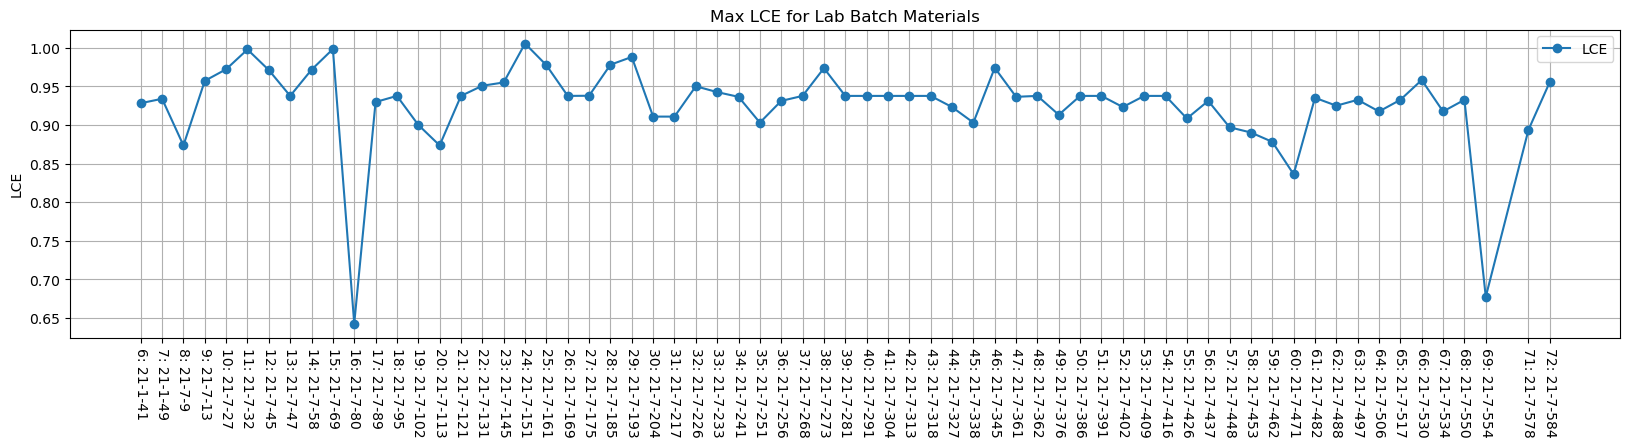

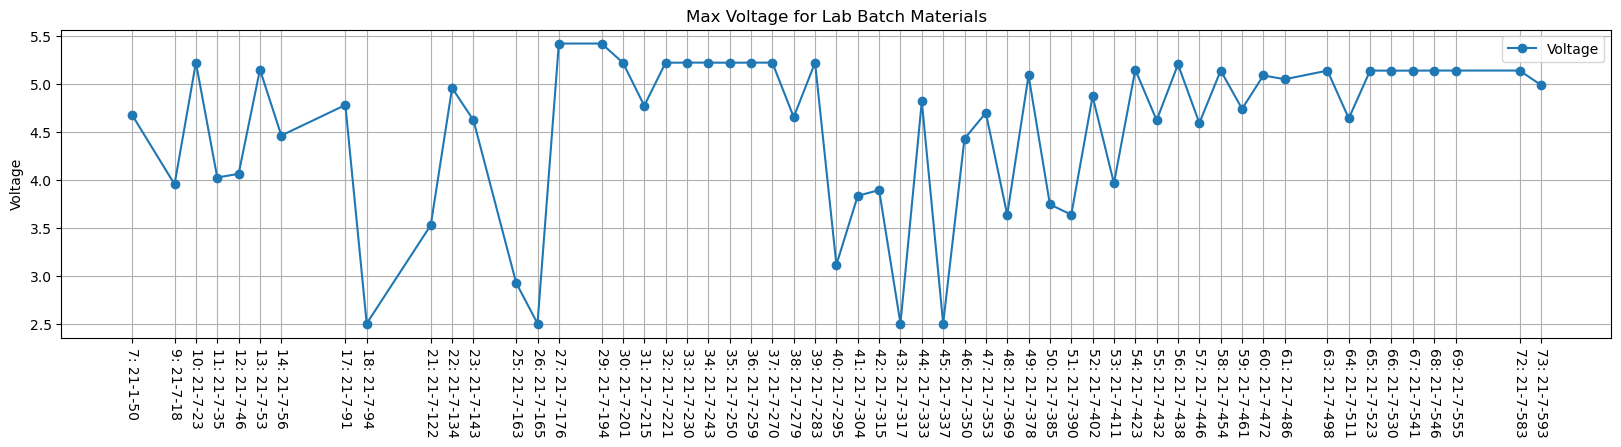

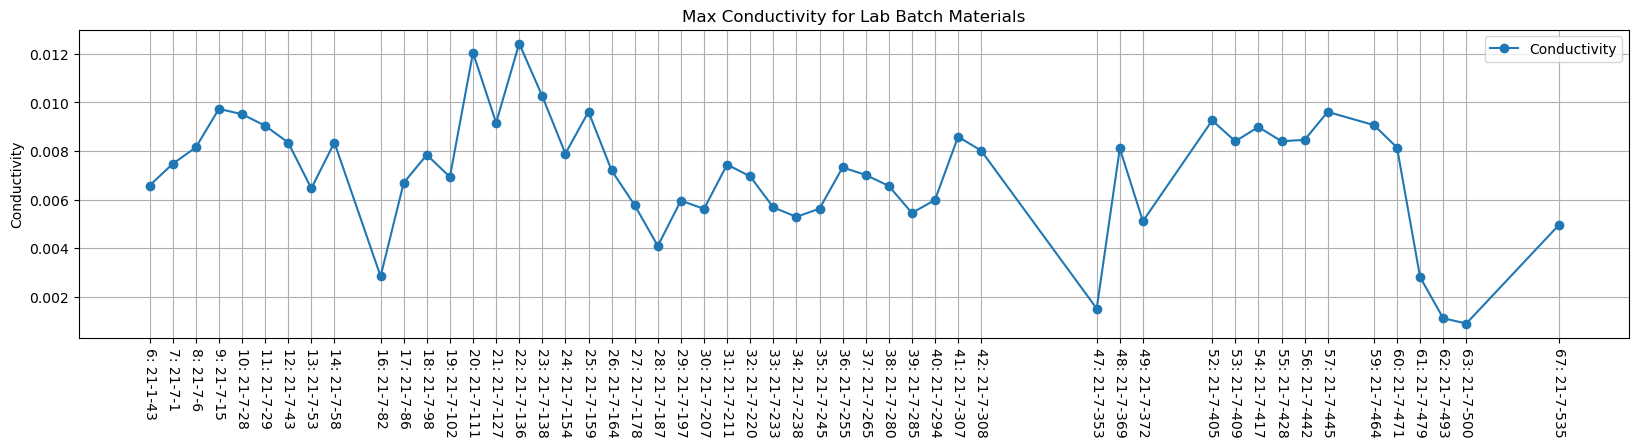

In [27]:
df = ds_lm.dataframe
for target in ["LCE", "Voltage", "Conductivity"]:

    indices_batch_max = []
    problematic_batches = []
    for batch, indices in df.groupby("lab_batch").groups.items():
        index_batch_max = df.loc[indices, target].idxmax()
        if not np.isnan(index_batch_max):
            indices_batch_max.append(index_batch_max)
        else:
            problematic_batches.append(batch)
    df_ = df.loc[indices_batch_max, ["lab_batch", "Electrolyte ID", target]]

    fig, ax = plt.subplots(figsize=(20,4))
    df_.plot(x="lab_batch", y=target, marker="o", ax=ax)
    ax.set_xticks(df_["lab_batch"])
    ticks = list(map(lambda x: str(int(x[0])) + ": " + x[1], df_.loc[:, ["lab_batch","Electrolyte ID"]].to_numpy()))
    ax.set_xticklabels(ticks, rotation=-90, ha="center", va="top")
    # if target == "LCE":
    #     ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel("")
    ax.set_title(f"Max {target} for Lab Batch Materials")
    ax.set_ylabel(target)
    ax.legend()
    ax.grid(1)

In [28]:
df_ = ds_lm.dataframe.dropna(subset=["LCE", "Predicted LCE"])
df_["id"] = df["Electrolyte ID"].str.replace("-", "").astype(int)
df_ = df_.sort_values(axis="index", by="id")
df_ = df_.loc[:, ["Electrolyte ID", "LCE", "Predicted LCE"]].reset_index(drop=True)

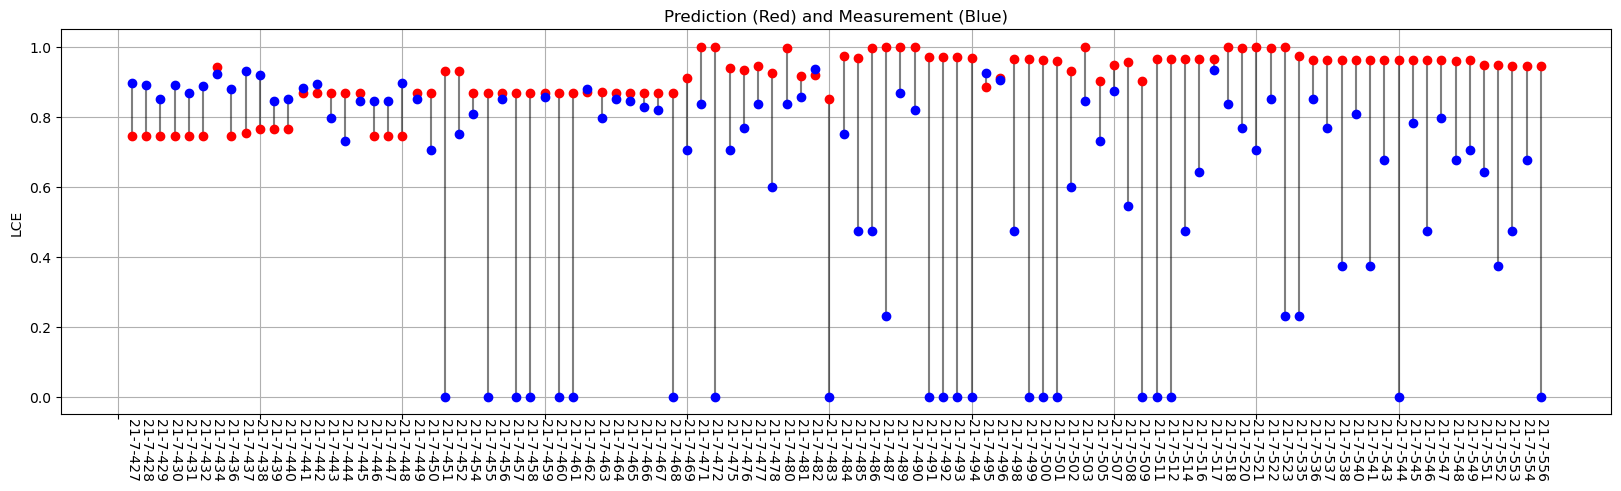

In [29]:
num_from_last = 100
fig, ax = plt.subplots(figsize=(20,5))
for row in df_.tail(num_from_last).iterrows():
    ax.plot([row[0]]*2, [row[1]["LCE"], row[1]["Predicted LCE"]], color="k", alpha=0.5)
    ax.plot(row[0], row[1]["Predicted LCE"], color="r", marker="o")
    ax.plot(row[0], row[1]["LCE"], color="b", marker="o")
    ax.text(row[0], -0.06, row[1]["Electrolyte ID"], rotation=-90, ha="center", va="top")
ax.set_xticks(np.arange(row[0]-num_from_last, row[0], 10))
ax.set_xticklabels([])
ax.set_title("Prediction (Red) and Measurement (Blue)")
ax.set_ylabel("LCE")
ax.grid(1, which="both", )
plt.show()

In [34]:
db = Database(db="bo_experiments")
df = db.pull(table="validated_lce_v1")

In [35]:
ds_lm = LiquidMasterDataSet(df)
ds_lm.map_names()
ds_lm.normalize_components(by="total_mass", inplace=True)
df_sort = ds_lm.dataframe.sort_values(axis="index", by="electrolyte_id")

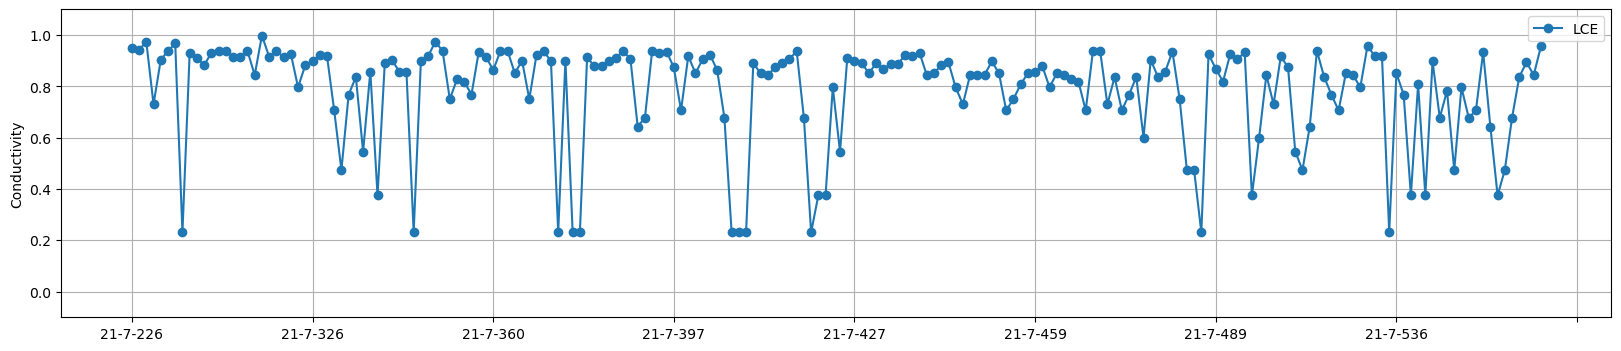

In [41]:
fig, ax = plt.subplots(figsize=(20,4))
df_sort.plot(x="electrolyte_id", y="LCE", marker="o", ax=ax)
# ax.set_xticks(df_sort["lab_batch"])
# ticks = list(map(lambda x: str(int(x[0])) + ": " + x[1], df_.loc[:, ["lab_batch","Electrolyte ID"]].to_numpy()))
# ax.set_xticklabels(ticks, rotation=-90, ha="center", va="top")
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel("")
ax.set_ylabel(target)
ax.legend()
ax.grid(1)

In [19]:
df_sort.tail(7).loc[:, ["electrolyte_id","LCE"]]

,electrolyte_id,LCE
179,21-7-534,0.917355
173,21-7-535,0.230769
174,21-7-536,0.850746
175,21-7-537,0.767442
176,21-7-538,0.375000
177,21-7-540,0.807692
178,21-7-541,0.375000


In [12]:
df_sel = df_cy.loc[df_cy["Method"] == "Aurbach"]
features = df_sel.loc[:, ['FC', 'OC', 'FO', 'InOr', 'F', 'sF', 'aF', 'O', 'sO', 'aO', 'C', 'sC', 'aC']]
targets = df_sel.loc[:, ["LLCE"]]

In [23]:
df_cy["Cycle"] = pd.to_numeric(df_cy["Cycle"], errors="coerce")

<AxesSubplot: xlabel='Cycle'>

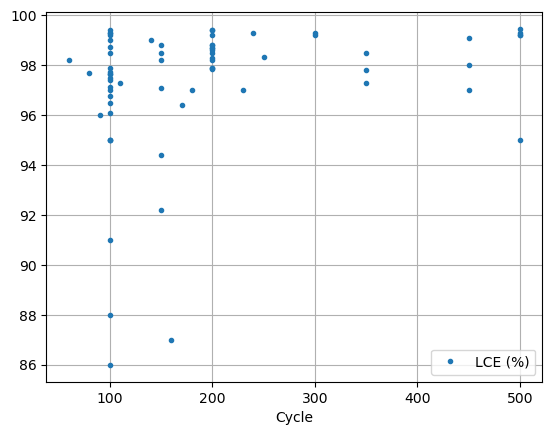

In [33]:
df_cy.loc[(df_cy["Cycle"]>50), ["Cycle", "LCE (%)"]].plot(x="Cycle", y="LCE (%)", marker=".", ls="", grid=True)